<a href="https://colab.research.google.com/github/essat20/NLP_CW_210021102/blob/main/NLP%20BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setting Up The IDE and importing the libraries Before Pre-processing

In [1]:
# downloading datasets
!pip install datasets # install the datasets from huggingface
!pip install transformers # used for the BERT model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 20.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


# Import Libraries

In [3]:

import torch
import torch.nn as nn
from transformers import DistilBertModel, DistilBertTokenizer, AdamW # everything for the BERT model
from datasets import load_dataset
from torch.utils.data import DataLoader # so i can load the dataset
from torch.nn.utils.rnn import pad_sequence # have to add padding library to ensure all sequences have the same length
from sklearn.metrics import confusion_matrix # so i can display the confusion matrix
import numpy as np
import matplotlib.pyplot as plt # this can be used to display loss/epoch graphs
import seaborn as sb # so i can display the confusion matrix as a heatmap


# Setting up and Preprocessing

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Mean sequence length: 19.1663125
Median sequence length: 17.0
Maximum sequence length: 66


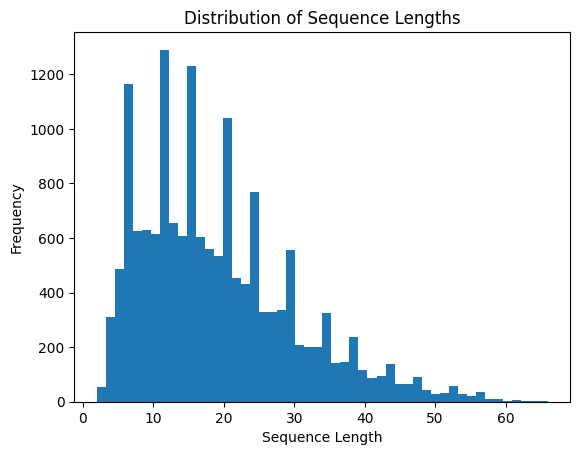

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # prepares GPU

# load the dataset
dataset = load_dataset('emotion', trust_remote_code=True) # have to use the second parameter as there is required custom code for the dataset to be loaded properly

# extract text sequences
texts = dataset['train']['text']

## need to know the maximum sequence length to adjsut the padding
sequence_lengths = [len(text.split()) for text in texts]
mean_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
max_length = max(sequence_lengths)

print("Mean sequence length:", mean_length)
print("Median sequence length:", median_length)
print("Maximum sequence length:", max_length)

# display the pad sequence lengths as a distrubution graph
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

#Pre-processing the data

In [5]:
# Load the DistilBert tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # to tokenise the data
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

The code below just defines the model architecture using a PyTorch neural network module. The SentimentClassifier class takes the DistilBERT model as input and defines the forward method. It extracts the last hidden state from the output of the DistilBERT model, and passes it through a linear layer to get the final logits.

# Defining the Classifier

In [6]:
# Define the model architecture
class SentimentClassifier(nn.Module):
    def __init__(self, model):
        super(SentimentClassifier, self).__init__()
        self.model = model
        self.linear = nn.Linear(768, 6)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs[0]
        logits = self.linear(last_hidden_state[:, 0, :])
        return logits

# Instantiate the model
model = SentimentClassifier(model)

The code below now defines the training and eval loop. It sets the model to training mode and iterates through each batch of the training data. It calculates the loss, computes the gradients, and updates the model parameters using the AdamW optimizer.

#Tokenisation and Defining Training/Evaluation functions

In [7]:
# Tokenize the data
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True, max_length=66) # 66 since largest sequence in dataset is 66, see results of distribution graph above

train_dataset = dataset['train'].map(tokenize, batched=True)
test_dataset = dataset['test'].map(tokenize, batched=True)

# Set the data format
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Set up the optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = nn.CrossEntropyLoss() # crossEntropyLoss and not BCE since there are 6 classes to classify between

# Define the training loop
def train(model, train_loader, optimizer, loss_fn, device, epoch_num):
    model.train()
    epoch_losses = [] # intialises the epoch losses, this will be appended to and then used to create the loss/epoch graph

    for epoch in range(epoch_num):
        iteration_loss = 0.0 # defines and initialises the current iteration loss to 0 so it can be used in the next part
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)  # had to add padding to my data since size mismatch in tensors being stacked during batching
            attention_mask = batch['attention_mask'].to(device)  # padding ensures all the sequences have the same length
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels.long()) # work out the loss
            print(loss)
            loss.backward() # backpropagation
            optimizer.step() # optimiser the weights
            iteration_loss+=loss.item()

        iteration_loss /= len(train_loader) # append iteration loss to list
        epoch_losses.append(iteration_loss)  # Append epoch loss to list
    print(f'Epoch: {epoch:.3f}') # prints the epochs after each iteration


    return epoch_losses



# evaluation for confusion matrix
def evaluate_cf(model, test_loader, device):
    model.eval()
    predictions = []
    labels = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            batch_labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            batch_predictions = torch.argmax(outputs, dim=1) # get the predicted labels

            predictions.extend(batch_predictions.tolist())
            labels.extend(batch_labels.tolist())

    return predictions, labels


# evaluation to calculate the accuracy of the model
def evaluate(model, test_loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            predictions = torch.argmax(outputs,dim=1)

            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    return correct / total

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Training the Model

tensor(1.7808, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6896, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5782, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6774, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7155, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6362, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5338, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4078, device='cuda:0', grad_fn=

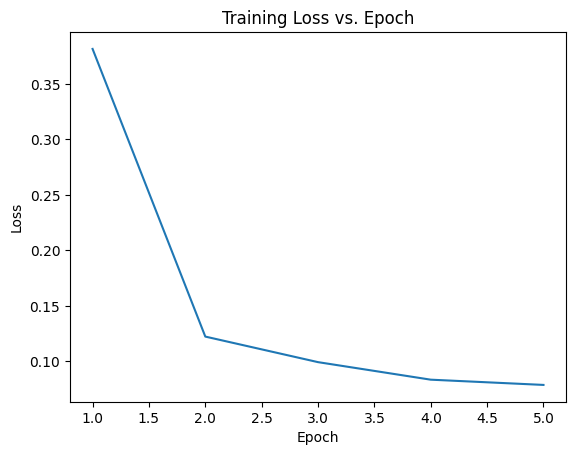

In [8]:
# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# pad the sequences
def collate_fn(batch):
  input_ids = [item['input_ids'] for item in batch]
  attention_mask = [item['attention_mask'] for item in batch]
  labels = [item['label'] for item in batch]

  input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
  attention_mask = pad_sequence(attention_mask,batch_first=True,padding_value=0)

  return {
      'input_ids': input_ids,
      'attention_mask': attention_mask,
      'label': torch.tensor(labels)
  }

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle = True, collate_fn = collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle = False, collate_fn = collate_fn)


epoch_num = 5

# calling the training function
# storing it as a variable so it can be use to plot a loss/epoch graph below
train_hist = train(model, train_loader, optimizer, loss_fn, device, epoch_num)
print("Length is: ", len(train_hist))

# calculating the accuracy of the model using the evaluate function
accuracy = evaluate(model, test_loader, device)
print(f'Test Accuracy: {accuracy:.3f}')

print("training history:")
print(train_hist)


 #Plot loss vs. epoch
plt.plot(range(1, epoch_num+1), train_hist)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs. Epoch')
plt.show()

#Display Confusion Matrix as Heatmap

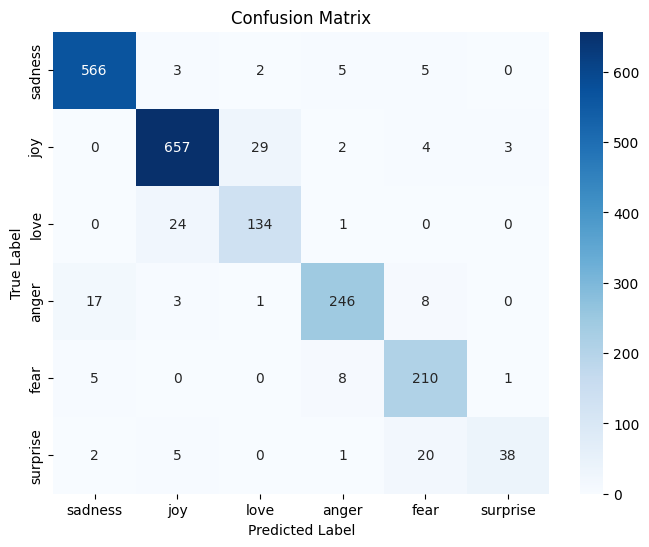

In [9]:
predictions, labels = evaluate_cf(model, test_loader, device)
conf_matrix = confusion_matrix(labels, predictions)

# plotting the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sb.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataset['train'].features['label'].names, yticklabels=dataset['train'].features['label'].names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [10]:
# simple confusion matrix for error analysis purposes
predictions, labels = evaluate_cf(model, test_loader, device)
conf_matrix = confusion_matrix(labels, predictions)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[566   3   2   5   5   0]
 [  0 657  29   2   4   3]
 [  0  24 134   1   0   0]
 [ 17   3   1 246   8   0]
 [  5   0   0   8 210   1]
 [  2   5   0   1  20  38]]
